     |████████████████████████████████| 15.7 MB 8.8 MB/s eta 0:00:01MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [5]:
# input image dimensions
img_rows, img_cols = 32, 32

In [6]:
# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [7]:
input_shape = (img_rows, img_cols, 3)

In [8]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 100

# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape} & X_test.shape: {X_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (50000, 32, 32, 3) & X_test.shape: (10000, 32, 32, 3)


In [9]:
load_outlier_detector = True
filepath = '/root/.keras/datasets/'
latent_dim = 2

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [15]:
# encoder_inputs = keras.Input(shape=(32, 32, 3))
# x = Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu)(encoder_inputs)
# x = Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu)(x)
# x = Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)(x)
# x = layers.Flatten()(x)
# x = layers.Dense(latent_dim, activation="relu")(x)
# z_mean = layers.Dense(latent_dim, name="z_mean")(x)
# z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
# z = Sampling()([z_mean, z_log_var])
# encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()

# latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(4*4*512)(latent_inputs)
# x = layers.Reshape(target_shape=(4, 4, 512))(x)
# x = Conv2DTranspose(128, 4, strides=2, padding='same', activation=tf.nn.relu)(x)
# x = Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu)(x)
# decoder_outputs = Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')(x)
# decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
# decoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 16, 16, 64)   3136        ['input_4[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 8, 8, 128)    131200      ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 4, 4, 512)    1049088     ['conv2d_4[0][0]']               
                                                                                            

In [25]:
# MODIFIED

encoder_inputs = keras.Input(shape=(32, 32, 3))
x = Conv2D(32, 3, strides=2, padding='same', activation=tf.nn.relu)(encoder_inputs)
x = Conv2D(64, 3, strides=2,  padding='same', activation=tf.nn.relu)(x)
# x = Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)(x)
x = layers.Flatten()(x)
x = layers.Dense(latent_dim, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8*8*64)(latent_inputs)
x = layers.Reshape(target_shape=(8, 8, 64))(x)
x = Conv2DTranspose(32, 3, strides=2, padding='same',  activation=tf.nn.relu)(x)
# x = Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu)(x)
decoder_outputs = Conv2DTranspose(3, 3, strides=2, padding='same',  activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 16, 16, 32)   896         ['input_24[0][0]']               
                                                                                                  
 conv2d_25 (Conv2D)             (None, 8, 8, 64)     18496       ['conv2d_24[0][0]']              
                                                                                                  
 flatten_11 (Flatten)           (None, 4096)         0           ['conv2d_25[0][0]']              
                                                                                            

In [26]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='reconstruction_loss', patience=3)

In [33]:
vae = VAE(encoder, decoder)
# vae.build(input_shape=(32, 32, 3))
# vae.summary()
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
vae.fit(X_train,epochs=10, batch_size=128)

Epoch 1/10
391/391 [==============================] - 6s 9ms/step - loss: 63.8542 - reconstruction_loss: 63.6817 - kl_loss: 2.2475e-04
Epoch 2/10
391/391 [==============================] - 4s 9ms/step - loss: 63.5577 - reconstruction_loss: 63.5125 - kl_loss: 1.1572e-04
Epoch 3/10
391/391 [==============================] - 4s 9ms/step - loss: 63.3499 - reconstruction_loss: 63.5020 - kl_loss: 7.4846e-05
Epoch 4/10
391/391 [==============================] - 4s 11ms/step - loss: 63.4434 - reconstruction_loss: 63.5075 - kl_loss: 5.0385e-05
Epoch 5/10
391/391 [==============================] - 3s 8ms/step - loss: 63.4478 - reconstruction_loss: 63.5013 - kl_loss: 4.3424e-05
Epoch 6/10
391/391 [==============================] - 3s 9ms/step - loss: 63.6461 - reconstruction_loss: 63.5031 - kl_loss: 5.0266e-05
Epoch 7/10
391/391 [==============================] - 4s 9ms/step - loss: 63.7728 - reconstruction_loss: 63.5024 - kl_loss: 3.5586e-05
Epoch 8/10
391/391 [==============================] - 

In [54]:
img=999
m, l, z = vae.encoder.predict(X_test[img].reshape(1,32,32,3))

In [55]:
dec = vae.decoder.predict(z)

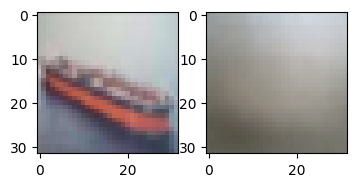

In [56]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4, 4))
axs = axs.flatten()
axs[0].imshow(X_test[img])
axs[1].imshow(dec[0])
plt.show()